# Regularization proof of concept


In [1]:
from __helpers import qubit_expansion, prepare_basis, rand_basis, param_to_unitary
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL, Em_MMD, MMD
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi, cos, sin, exp
from qiskit.quantum_info import Statevector
%matplotlib inline

In [2]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.

When using KL, set `OPS = None`. When using Em_MMD, set `ops = s` 
where `s` is the desired MMD parameter.
"""
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 3
NUM_BASES = 2
USE_REGULARIZER = False
JUMP = True
LOSS_METRIC = KL
ESTIMATE = False
SAMPLE = False
NOISE_SCALE = 5
OPS = None # MMD sigma parameter

      ┌───┐          
q0_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q0_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q0_2: ──────────┤ X ├
                └───┘


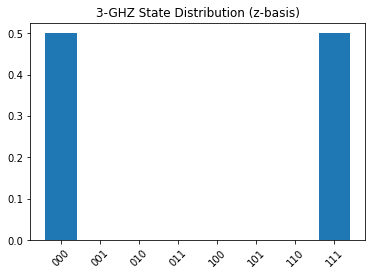

In [3]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'mGHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from mGHZ_generator import mGHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = mGHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.xticks(rotation=45)
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

In [4]:
# Preparation of two bases
bases = prepare_basis(state.num_qubits, num=NUM_BASES)
num_bases = len(bases)

Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
3-qubit (noise: 0) non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


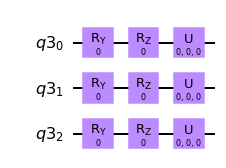

In [5]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=1e-2, maxiter=5E3, disp=disp,
            mode='Nelder-Mead', depth=CIRCUIT_DEPTH, 
            estimate=ESTIMATE, s_eps=NOISE_SCALE, 
            metric_func=LOSS_METRIC, ops=OPS, sample=SAMPLE, 
            regularize=USE_REGULARIZER, jump=JUMP)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [6]:
# Optimize a few times.
NRUN = 3
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
# x0 = np.array([3.1416, 1.8676, 3.9111, 3.1416, 0.0572, 3.4207, 3.1416, 1.2177, 8.6164]) # Off diag
x0 = np.array([6.2832, 4.6871, 1.5150, 6.2832, 6.8319, 1.4635, 6.2832, 7.3298, 2.4352]) # diag
# x0 = None # random
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True, x0=x0)
    if USE_REGULARIZER:
        print(f"Regularizer loss = {regularizer_loss}")
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

Jumped to: 
[[[ 0.23344541+0.j          0.82099903+0.52102192j]
  [-0.27128265-0.93376065j -0.06512908+0.22417619j]]

 [[ 0.04710643+0.j         -0.58713257+0.80811901j]
  [-0.9398362 -0.33836209j -0.0389608 +0.02647775j]]

 [[-0.50904133+0.j         -0.3418419 -0.78995002j]
  [-0.62745388-0.5892186j  -0.17243168+0.47894717j]]]

Jumped to: 
[[[ 0.98510932+0.j         -0.17184427-0.00540042j]
  [-0.01079552-0.17158985j -0.03094303-0.98462323j]]

 [[-0.2334455 +0.j         -0.57154452+0.78666388j]
  [-0.96470247+0.12187023j  0.11246314-0.2045699j ]]

 [[-0.18738143+0.j         -0.73682453-0.6495982j ]
  [ 0.75686529+0.62613348j -0.0293129 -0.18507446j]]]

Jumped to: 
[[[-0.91775469+0.j          0.1108007 -0.38137847j]
  [ 0.22323013+0.32847319j  0.87283663-0.28360162j]]

 [[-0.91140334+0.j         -0.35420767+0.20947763j]
  [ 0.02583921-0.41070219j  0.41376807+0.81206652j]]

 [[-0.6959128 +0.j          0.42210419+0.58097628j]
  [-0.30576337+0.64978007j -0.68358622+0.13040131j]]]

Jumped 

## Quantum Training Validation

In [7]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    for j, basis_here in enumerate(bases):
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = 3.530603396195215e-05
[B1] KL = 2.5689364973552104e-05
[B0] KL = 9.595954444680824e-06
[B1] KL = 5.428351362265742e-06
[B0] KL = 6.121177793008987e-05
[B1] KL = 0.00010380578475922332


## Quantum Loss Cross-Validation

In [8]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    for j in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = 0.0022414567720244467
[B1] KL = 0.00017590830267425308
[B2] KL = 0.0003063076758181391
[B0] KL = 0.0010262244181825386
[B1] KL = 0.0002651647583164123
[B2] KL = 2.0613097244274754e-05
[B0] KL = 0.015599750476935452
[B1] KL = 0.003546009140165108
[B2] KL = 0.0018739223976692474


## Regularization validation

In [9]:
# Convert the proposed symmetries to unitaries
for i, sym in enumerate(proposed_syms):
    sym = sym.reshape((NUM_QUBITS, -1)).numpy()
    unitary = np.around(param_to_unitary(sym), 4)
    print(f"[S{i}] Operator = \n {unitary}")

[S0] Operator = 
 [[[ 1.000e+00+0.j     -2.400e-03+0.0023j]
  [-2.500e-03+0.0022j -1.113e-01+0.9938j]]

 [[-1.000e+00+0.j      3.900e-03+0.001j ]
  [-4.000e-04-0.004j   1.626e-01-0.9867j]]

 [[-1.000e+00+0.j      7.000e-04-0.0032j]
  [ 2.600e-03-0.002j  -4.245e-01-0.9054j]]]
[S1] Operator = 
 [[[-4.000e-04+0.000e+00j  4.308e-01+9.024e-01j]
  [ 8.672e-01+4.979e-01j -0.000e+00+4.000e-04j]]

 [[ 2.800e-03+0.000e+00j  9.790e-01-2.040e-01j]
  [-3.032e-01+9.529e-01j  3.000e-04-2.800e-03j]]

 [[ 1.800e-03+0.000e+00j -3.224e-01+9.466e-01j]
  [ 7.806e-01+6.250e-01j  1.500e-03-1.000e-03j]]]
[S2] Operator = 
 [[[ 6.500e-03+0.000e+00j  2.125e-01-9.771e-01j]
  [ 1.000e+00-9.000e-04j -1.400e-03+6.300e-03j]]

 [[ 4.600e-03+0.000e+00j  4.586e-01-8.887e-01j]
  [ 7.178e-01+6.962e-01j -4.400e-03+1.500e-03j]]

 [[-1.000e-04+0.000e+00j  9.521e-01-3.058e-01j]
  [-5.256e-01+8.508e-01j -0.000e+00+1.000e-04j]]]


In [10]:
print(proposed_syms[0])

tensor([-0.0066,  5.5734,  2.3921,  6.2913,  1.4766,  0.2576,  6.2767,  5.6218,
         1.7938])
